In [1]:
!conda env list

# conda environments:
#
base                     /home/gui/anaconda3
astronomy                /home/gui/anaconda3/envs/astronomy
iclinic                  /home/gui/anaconda3/envs/iclinic
kaggle                *  /home/gui/anaconda3/envs/kaggle
pong                     /home/gui/anaconda3/envs/pong
pyautogui                /home/gui/anaconda3/envs/pyautogui
pygame                   /home/gui/anaconda3/envs/pygame



In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from pprint import pprint
import time

In [3]:
file = 'titanic/train.csv'
df = pd.read_csv(file)

In [4]:
X = df.drop(['Survived'], axis=1)
y = df.Survived

## EDA

In [5]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
69,70,0,3,"Kink, Mr. Vincenz",male,26.0,2,0,315151,8.6625,NaN,S
51,52,0,3,"Nosworthy, Mr. Richard Cater",male,21.0,0,0,A/4. 39886,7.8000,NaN,S
665,666,0,2,"Hickman, Mr. Lewis",male,32.0,2,0,S.O.C. 14879,73.5000,NaN,S
833,834,0,3,"Augustsson, Mr. Albert",male,23.0,0,0,347468,7.8542,NaN,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S


In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


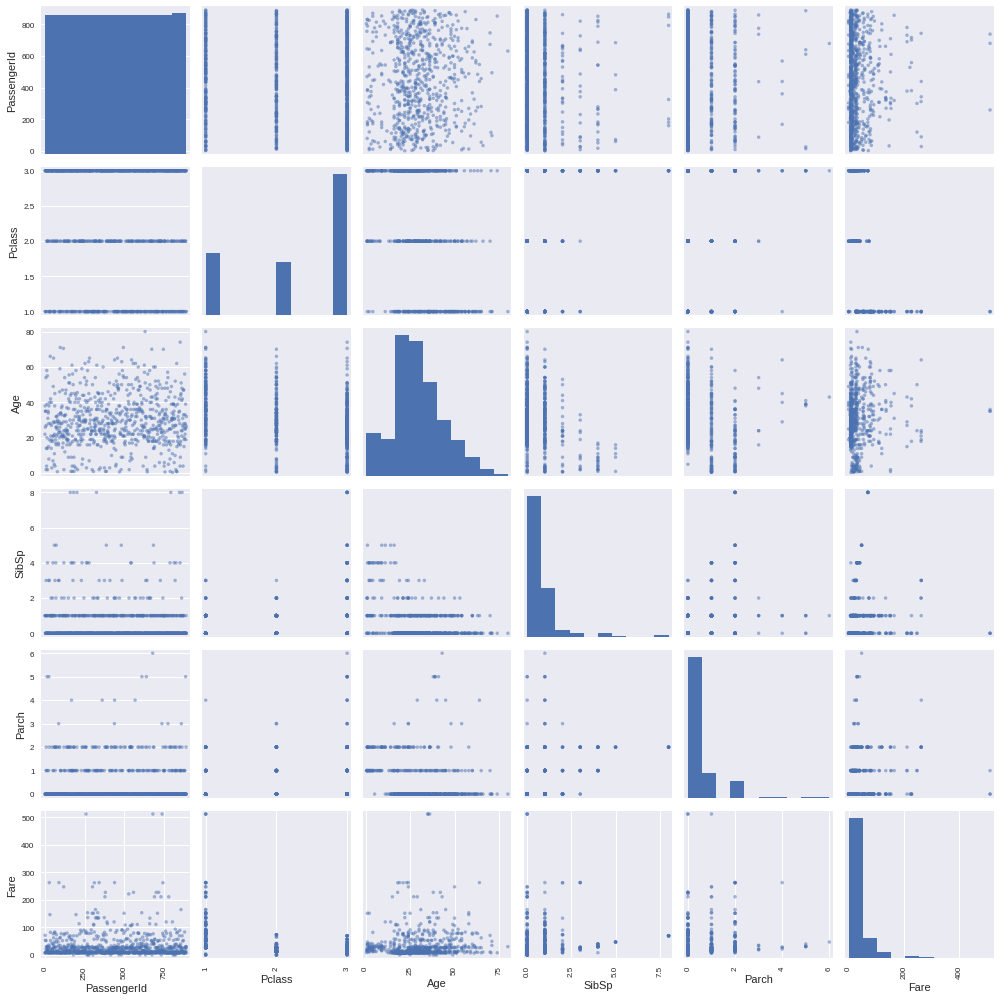

In [8]:
pd.plotting.scatter_matrix(X, figsize=(14, 14))
plt.tight_layout()
plt.show()

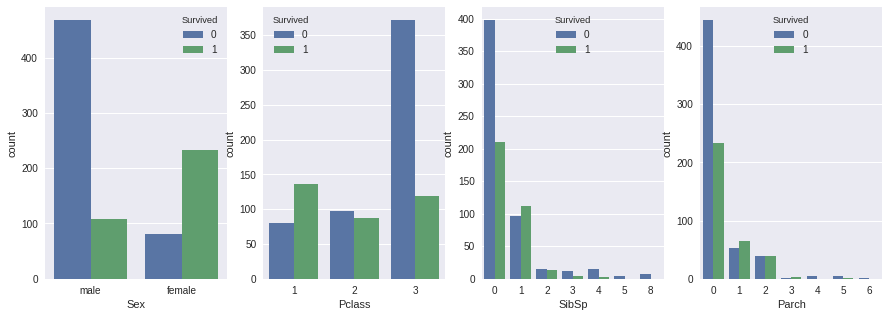

In [9]:
plt.figure(figsize=(15, 5))
cols = ['Sex', 'Pclass', 'SibSp', 'Parch']
for p, x in enumerate(cols, 1):
    plt.subplot(1, len(cols), p)
    sns.countplot(x, data=X, hue=y);

### Fatores protetores:
1. Sexo feminino
2. Não estar na terceira classe
3. ter família, mas pequena (1 ou 2 Parch ou SibSp)

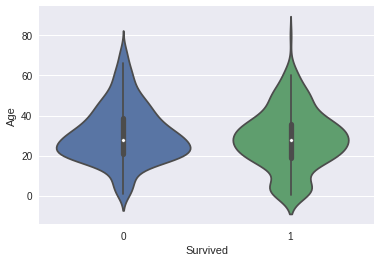

In [10]:
sns.violinplot(y='Age', x='Survived', data=df);

## Preprocessing

### Age

Since children have more chance of survival than adults, is better separate the averages to input.

In [11]:
X.Age.isna().sum()

177

In [12]:
children = X[X.Name.str.contains('Master', case=False, regex=False)].index
adults = X.drop(children, axis=0).index
adults.shape, children.shape

((851,), (40,))

In [13]:
avg_age_children = X.loc[children, 'Age'].median()
avg_age_adults = X.loc[adults, 'Age'].median()
avg_age_adults, avg_age_children

(29.0, 3.5)

In [14]:
X.loc[children, 'Age'] = X.loc[children, 'Age'].apply(lambda x: avg_age_children if np.isnan(x) else x)
X.loc[adults, 'Age'] = X.loc[adults, 'Age'].apply(lambda x: avg_age_adults if np.isnan(x) else x)

### Ticket, Cabin, Name, PassengerId

Name and PasPassengerId have too much categories to deal with.

In [15]:
print(len(df.Ticket.value_counts()))

681


Ticket feature has 681 categories. I seems that's not usefull to use this way. Maybe if I make some groups.

In [16]:
print('Number of values:', len(df.Cabin.value_counts()))
print('Null:', df.Cabin.isnull().sum())

Number of values: 147
Null: 687


Cabin has too much null values and to much categories. (Make some groups?)

In [17]:
X = X.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1)

### Sex and Embarked

Low number of categories, no null values.

In [18]:
X = pd.get_dummies(X)

In [19]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [20]:
def preprocessing(file, train=True):
    '''
    Parameters:
    ===========
    file: path too file to preprocess
    
    Returns:
    ========
    tuple (X, y) if train, (X, ids) if not train
    
    '''
    X = pd.read_csv(file)
    ids = X.PassengerId
    list_to_drop = ['Cabin', 'Name', 'PassengerId', 'Ticket']
    if train:
        list_to_drop.append('Survived')
        y = df.Survived
        
    children = X[X.Name.str.contains('Master', case=False, regex=False)].index
    adults = X.drop(children, axis=0).index
    adults.shape, children.shape

    avg_age_children = X.loc[children, 'Age'].median()
    avg_age_adults = X.loc[adults, 'Age'].median()
    avg_age_adults, avg_age_children

    X.loc[children, 'Age'] = X.loc[children, 'Age'].apply(lambda x: avg_age_children if np.isnan(x) else x)
    X.loc[adults, 'Age'] = X.loc[adults, 'Age'].apply(lambda x: avg_age_adults if np.isnan(x) else x)

    X = X.drop(list_to_drop, axis=1)
    X = pd.get_dummies(X)
    
    if train:
        return X, y
    else:
        return X, ids

## Machine Learning

### Baseline

In [30]:
file = 'titanic/train.csv'
X, y = preprocessing(file)

params = {
    'objective': 'binary:logistic',
}

dtrain = xgb.DMatrix(X, y)
cv = xgb.cv(params, dtrain, num_boost_round=100, early_stopping_rounds=10, metrics='map')
cv.tail()

,train-map-mean,train-map-std,test-map-mean,test-map-std
4,0.920038,0.004830,0.841679,0.023177
5,0.925956,0.003750,0.843168,0.022079
6,0.928132,0.006606,0.846643,0.019920
7,0.931994,0.005128,0.850582,0.020309
8,0.940235,0.001115,0.865090,0.006197


## Pipeline

In [144]:
# train files
file = 'titanic/train.csv'
X_train, y_train = preprocessing(file)

In [145]:
# test file
file = 'titanic/test.csv'
X_test, ids = preprocessing(file, train=False)

In [148]:
# ML with all the sample

std_scaler = StandardScaler()
clf = xgb.XGBClassifier(n_jobs=-1, num_boost_round=100, early_stopping_rounds=10, metrics='map')

steps = [
    ('scaler', std_scaler),
    ('model', clf)
]

pipe = Pipeline(steps)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

In [153]:
# make submission file
df_subm = pd.DataFrame({'PassengerId': ids, 'Survived': y_pred})
nonce = round(time.time() * 1000) # time in msec
df_subm.to_csv('titanic/submissions/subm_{}.csv'.format(nonce), index=False)

In [18]:
# https://github.com/Kaggle/kaggle-api
import kaggle

# have to write the name of the file mannually
# !kaggle competitions submit titanic -f titanic/submissions/subm_1556792572215.csv
!git add titanic.ipynb
!git commit -m 'dev/kaggle/kaggle_titanic/titanic/submissions/subm_1556792572215.csv'

In [22]:
!git status

No ramo master
Your branch is up to date with 'origin/master'.

Mudanças a serem submetidas:
  (use "git reset HEAD <file>..." to unstage)

	modified:   .gitignore
	new file:   titanic.ipynb

